In [1]:
import sys
import os

# Add the src directory to the Python path
src_path = os.path.join(os.getcwd(), 'src')
if src_path not in sys.path:
    sys.path.append(src_path)

In [2]:
import numpy as np
import pandas as pd
import itertools
from sklearn.model_selection import train_test_split
from src.optimizers import *
from src.activation_functions import * 
from src.utils import *
from src.model_regularization import *
from src.layer import *
from src.batch_normalization import *
from src.random_search import *
from sklearn.preprocessing import StandardScaler
from src.loss_functions import *
np.random.seed(0)

In [3]:
df_path = "../ML_project/data/cup/ML-CUP24-TR.csv"
df_path2 = "../ML_project/data/cup/ML-CUP24-TS.csv"

# df = pd.read_csv(df_path, skiprows=7, header=None)
df = pd.read_csv(df_path2, skiprows=7, header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,1,0.964008,0.249750,0.621279,-0.251304,0.967891,0.005800,-0.086798,-0.028503,0.995818,20.769237,4.786694,0.414053
1,2,-0.976968,-0.189726,-1.128659,0.190555,-0.981676,0.000850,-0.096032,-0.017779,0.995219,19.189428,2.239992,-0.218716
2,3,0.130254,0.986475,0.924671,-0.991395,0.130904,0.000001,-0.013024,-0.098648,0.995037,-10.339886,1.000085,0.099999
3,4,-0.153785,0.983480,0.744844,-0.988026,-0.154274,-0.002289,0.012480,-0.094696,0.995428,-0.650716,3.219906,0.303438
4,5,-0.655386,-0.749436,-1.182304,0.752975,-0.658039,-0.003522,-0.059142,-0.073003,0.995577,0.490563,3.837265,-0.350978


#### Data pre-processing for CUP DATASET 

In [4]:
def normalize(data, scaler=None, type="minmax"):
    """
    Normalize data using either min-max or z-score normalization.
    Can use a pre-fitted scaler or create a new one.

    Parameters:
    - data: DataFrame or array to normalize
    - scaler: Pre-fitted scaler (if None, a new one is created)
    - type: Type of normalization ('minmax' or 'z-score')

    Returns:
    - normalized_data: Normalized data
    - scaler: The scaler used (for inverse transformation)
    """
    if not isinstance(data, pd.DataFrame):
        data = pd.DataFrame(data)

    # Select numeric columns only for normalization
    numeric_data = data.select_dtypes(include=["float64", "int64"])

    if scaler is None:
        if type == "minmax":
            from sklearn.preprocessing import MinMaxScaler
            scaler = MinMaxScaler()
        elif type == "zscore" or type == "z-score":
            scaler = StandardScaler()
        else:
            raise ValueError(
                "Normalization type must be 'minmax' or 'z-score'")

        normalized_array = scaler.fit_transform(numeric_data)
    else:
        normalized_array = scaler.transform(numeric_data)

    normalized_data = pd.DataFrame(
        normalized_array,
        columns=numeric_data.columns,
        index=numeric_data.index
    )

    # Rejoin with non-numeric columns if needed
    non_numeric_data = data.select_dtypes(exclude=["float64", "int64"])
    if not non_numeric_data.empty:
        final_data = pd.concat([non_numeric_data, normalized_data], axis=1)
    else:
        final_data = normalized_data

    return final_data, scaler


def train_val_split(X, y, val_ratio=0.2, seed=42, shuffle=True):
    """
    Split X and y into training and validation sets.

    Parameters:
    - X: features DataFrame or array
    - y: target DataFrame or array
    - val_ratio: fraction of data to use for validation
    - seed: random seed for reproducibility
    - shuffle: whether to shuffle before splitting

    Returns:
    - X_train, X_val, y_train, y_val
    """
    assert len(X) == len(y), "X and y must have the same number of samples"

    n_samples = len(X)
    n_val = int(n_samples * val_ratio)

    indices = np.arange(n_samples)
    if shuffle:
        np.random.seed(seed)
        np.random.shuffle(indices)

    val_indices = indices[:n_val]
    train_indices = indices[n_val:]

    X_train = X.iloc[train_indices] if isinstance(
        X, pd.DataFrame) else X[train_indices]
    y_train = y.iloc[train_indices] if isinstance(
        y, pd.DataFrame) else y[train_indices]
    X_val = X.iloc[val_indices] if isinstance(
        X, pd.DataFrame) else X[val_indices]
    y_val = y.iloc[val_indices] if isinstance(
        y, pd.DataFrame) else y[val_indices]

    return X_train, X_val, y_train, y_val

In [5]:


# Main preprocessing function
def preprocess_data(filepath, normalize_targets=True):
    """
    Load and preprocess the dataset.
    
    Parameters:
    - filepath: Path to the CSV file
    - normalize_targets: Whether to normalize target values
    
    Returns:
    - Preprocessed data and scalers for inverse transformation
    """
    # Load data
    df = pd.read_csv(filepath, skiprows=7, header=None)
    df.columns = [
        "ID"] + [f'input_{i}' for i in range(12)] + ['target_x', 'target_y', 'target_z']
    df = df.drop('ID', axis=1)

    # Split features and targets
    y = df[['target_x', 'target_y', 'target_z']]
    X = df.drop(['target_x', 'target_y', 'target_z'], axis=1)

    # Normalize features
    X_normalized, X_scaler = normalize(X, type='z-score')

    # Split into train and validation sets

    X_train, X_validation, y_train, y_validation = train_val_split(
        X_normalized, y)

    # Normalize targets if requested
    if normalize_targets:
        y_train_df = pd.DataFrame(y_train)
        y_validation_df = pd.DataFrame(y_validation)

        y_train_normalized, y_scaler = normalize(y_train_df, type='z-score')
        y_validation_normalized, _ = normalize(
            y_validation_df, scaler=y_scaler, type='z-score')

        # Convert to numpy arrays
        X_train_np = np.array(X_train)
        X_validation_np = np.array(X_validation)
        y_train_np = np.array(y_train_normalized)
        y_validation_np = np.array(y_validation_normalized)
    else:
        # Convert to numpy arrays without normalizing targets
        X_train_np = np.array(X_train)
        X_validation_np = np.array(X_validation)
        y_train_np = np.array(y_train)
        y_validation_np = np.array(y_validation)
        y_scaler = None

    return {
        'X_train': X_train_np,
        'X_validation': X_validation_np,
        'y_train': y_train_np,
        'y_validation': y_validation_np,
        'X_scaler': X_scaler,
        'y_scaler': y_scaler
    }

In [61]:
# filepath = "../ML_project/data/cup/ML-CUP24-TR.csv"
# df = pd.read_csv(filepath, skiprows=7, header=None)
# df.columns = ["ID"] + [f'input_{i}' for i in range(12)] + ['target_x', 'target_y', 'target_z']
# df = df.drop('ID', axis=1)
# X = df.iloc[:,:-3]
# target=['target_x', 'target_y', 'target_z']
# y= df[target]
# # X.head()
# X_train, X_validation, y_train, y_validation = train_test_split(X,y, test_size=0.2, random_state=42)
# y_validation.head()
# X_train = normalize(data=X_train, type='z-score')
# X_validation = normalize(data=X_validation, type='z-score')

In [62]:
# filepath = "../ML_project/data/cup/ML-CUP24-TS.csv"
# df = pd.read_csv(filepath, skiprows=7, header=None)
# df.columns = ["ID"] + [f'input_{i}' for i in range(12)]
# df = df.drop('ID', axis=1)
# X_test = df.iloc[:, :12]  
# X_test = normalize(data=X_test, type='z-score')
# print("X_test.shape: ", X_test.shape)
# X_test

In [63]:
# filepath1 = "../ML_project/data/cup/ML-CUP24-TS.csv"
# filepath2 = "../ML_project/data/cup/ML-CUP24-TR.csv"

# df = pd.read_csv(filepath, skiprows=7, header=None)
# df.head()

### Training datasets

In [6]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# filepath = "../ML_project/data/cup/ML-CUP24-TS.csv"
filepath = "../ML_project/data/cup/ML-CUP24-TR.csv"


data = preprocess_data(filepath, normalize_targets=True)
# Unpack the returned dictionary
X_train = data['X_train']
X_validation = data['X_validation']
y_train = data['y_train']
y_validation = data['y_validation']


### Test datasets

In [7]:
# filepath_test = "../ML_project/data/cup/ML-CUP24-TS.csv"
# dataset = preprocess_data(filepath, normalize_targets=True)

# # X_test = dataset['X_s']
# # X_validation = dataset['X_validation']
# # y_train = dataset['y_train']
# # y_test = dataset['y_scaler']
# dataset


filepath_test = "../ML_project/data/cup/ML-CUP24-TS.csv"
df = pd.read_csv(filepath_test, skiprows=7, header=None)
df.columns = ["ID"] + [f'input_{i}' for i in range(12)]
df = df.drop('ID', axis=1)
X_test = df.iloc[:, :12]
# X_test = normalize(data=X_test, type='z-score')
# print("X_test.shape: ", X_test)
X_test.shape

(500, 12)

In [8]:

# Print the shape of the resulting datasets

print("Training Features Shape:", X_train.shape)

print("Validation Features Shape:", X_validation.shape)

print("Training Target Shape:", y_train.shape)

print("Validation Target Shape:", y_validation.shape)

Training Features Shape: (200, 12)
Validation Features Shape: (50, 12)
Training Target Shape: (200, 3)
Validation Target Shape: (50, 3)


In [66]:
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [9]:
class NN:
    def __init__(self, l1, l2, input_size, hidden_sizes, output_size, 
                 hidden_activations=None, dropout_rates=None, 
                 use_batch_norm=None, output_activation=Activation_Sigmoid()):
        self.layers = []
        prev_size = input_size

        # Default activations to ReLU
        if hidden_activations is None:
            hidden_activations = [Activation_ReLU() for _ in hidden_sizes]

        # Default dropout rates to 0
        if dropout_rates is None:
            dropout_rates = [0.0] * len(hidden_sizes)

        # Default batch_norm to False for all layers
        if use_batch_norm is None:
            use_batch_norm = [False] * len(hidden_sizes)
        else:
            assert len(use_batch_norm) == len(hidden_sizes), \
                "use_batch_norm must have the same length as hidden_sizes"

        # Create hidden layers
        for size, activation, rate, bn_flag in zip(hidden_sizes, hidden_activations, 
                                                 dropout_rates, use_batch_norm):
            # Add dense layer
            self.layers.append(Layer_Dense(prev_size, size, l1=l1, l2=l2))

            # Add batch normalization if specified
            if bn_flag:
                self.layers.append(BatchNormalization())

            # Add activation
            self.layers.append(activation())

            # Add dropout if rate > 0
            if rate > 0:
                self.layers.append(Dropout(rate))

            prev_size = size

        # Output layer
        self.layers.append(Layer_Dense(prev_size, output_size))
        # self.layers.append(output_activation)

    def forward(self, inputs, training=True):
        for layer in self.layers:
            # Pass training flag to relevant layers
            if isinstance(layer, (Dropout, BatchNormalization)):
                layer.forward(inputs, training=training)
            else:
                layer.forward(inputs)
            inputs = layer.output
        self.output = inputs
        return self.output

In [10]:
class Loss:
    def calculate(self, output, y):
        sample_losses = self.forward(output, y)
        data_loss = np.mean(sample_losses)
        return data_loss

class Loss_CategoricalCrossentropy(Loss):
    def forward(self, y_pred, y_true):
        samples = len(y_pred)
        y_pred_clipped = np.clip(y_pred, 1e-7, 1-1e-7)

        if len(y_true.shape) == 1:
            correct_confidence = y_pred_clipped[range(samples), y_true]

        elif len(y_true.shape) == 2:
            correct_confidence = np.sum(y_pred_clipped * y_true, axis=1) 

        negative_log_likelihoods = np.log(correct_confidence)
        return negative_log_likelihoods

    def backward(self, dvalues, y_true):

        # Number of samples
        samples = len(dvalues)
        # Number of labels in every sample
        # We'll use the first sample to count them
        labels = len(dvalues[0])

        # If labels are sparse, turn them into one-hot vector
        if len(y_true.shape) == 1:
            y_true = np.eye(labels)[y_true]

        # Calculate gradient
        self.dinputs = -y_true / dvalues
        # Normalize gradient
        self.dinputs = self.dinputs / samples


class Activation_Softmax_Loss_CategoricalCrossentropy():

    def __init__(self):
        self.activation = Activation_Softmax()
        self.loss = Loss_CategoricalCrossentropy()


    def forward(self, inputs, y_true):
        # Output layer's activation function
        self.activation.forward(inputs)

        # Set the output
        self.output = self.activation.output

        return self.loss.calculate(self.output, y_true)

    def backward(self, dvalues, y_true):
        samples = len(dvalues)

        if len(y_true.shape) == 2:
            y_true = np.argmax(y_true, axis=1)

        self.dinputs = dvalues.copy()

        self.dinputs[range(samples), y_true] -= 1

        self.dinputs = self.dinputs / samples

class MSE:
    def __init__(self):
        self.dinputs = 0
        self.loss = 0
        self.output = 0
        
        
    def forward(self, y_pred, y_true):
        self.output = np.mean((y_pred - y_true)**2)
        return self.output
    
    def backward(self, dvalues, y_true):
        samples = len(dvalues)
        outputs = len(dvalues[0])
        
        self.dinputs = -2 * (y_true - dvalues) / outputs
        self.dinputs = self.dinputs / samples
        
class MEE:
    def __init__(self):
        self.dinputs = 0
        self.loss = 0
        self.output = 0
    
    def forward(self, y_pred, y_true):
        self.output = np.mean(np.sqrt(np.sum((y_pred - y_true)**2, axis=1)))
        return self.output
    
    def backward(self, dvalues, y_true):
        # Number of samples and outputs
        samples = len(dvalues)
        outputs = len(dvalues[0])

        differences = dvalues - y_true
        euclidean_distances = np.sqrt(np.sum(differences**2, axis=1, keepdims=True))
        
        # Avoid division by zero
        euclidean_distances = np.maximum(euclidean_distances, 1e-7)

        self.dinputs = differences / euclidean_distances
        
        # Normalize by number of samples and outputs
        self.dinputs = self.dinputs / (samples * outputs)
        
        return self.dinputs

In [11]:
# param_distributions = {
#     'hidden_size': [[12, 10]],
#     'hidden_activation': [[Activation_Tanh], [Activation_Leaky_ReLU], [Activation_Sigmoid], [Activation_ReLU]],
#     'batch_norm': [[True], [False]],
#     'learning_rate': [1e-4, 1e-3, 1e-2, 1e-1],
#     'l1': [0.0, 1e-5, 1e-4, 1e-3, 1e-2],
#     'l2': [0.0, 1e-5, 1e-4, 1e-3, 1e-2],
#     'dropout_rate': [0.0, 0.1, 0.3],
#     'batch_size': [1000],
#     'n_epochs': [150, 200],
#     'weight_decay': list(np.arange(0.0, 0.05, 0.01))
#     # # Define combinations of hidden layer sizes and corresponding activations
#     # 'hidden_configs': [
#     #     {'hidden_size': [10], 'hidden_activation': [Activation_Tanh], 'batch_norm' : [True]},
#     #     {'hidden_size': [10, 10], 'hidden_activation': [Activation_Leaky_ReLU, Activation_ELU], 'batch_norm' : [True, True]},
#     #     {'hidden_size': [10, 10], 'hidden_activation': [Activation_Leaky_ReLU, Activation_ELU], 'batch_norm' : [True, True]},
#     #     {'hidden_size': [20, 20], 'hidden_activation': [Activation_Leaky_ReLU, Activation_ELU], 'batch_norm' : [True, False]},
#     #     {'hidden_size': [20, 20], 'hidden_activation': [Activation_Leaky_ReLU, Activation_ELU], 'batch_norm' : [True, True]},
#     #     {'hidden_size': [20, 20], 'hidden_activation': [Activation_ELU, Activation_ELU], 'batch_norm' : [True, False]},
#     #     {'hidden_size': [10, 10], 'hidden_activation': [Activation_Leaky_ReLU, Activation_ELU], 'batch_norm' : [True, False]},
#     #     {'hidden_size': [32, 16], 'hidden_activation': [Activation_Leaky_ReLU, Activation_Sigmoid], 'batch_norm' : [False, True]},
#     #     {'hidden_size': [30, 30], 'hidden_activation': [Activation_Leaky_ReLU, Activation_ELU], 'batch_norm' : [True, False]},
#     #     {'hidden_size': [64, 32, 16], 'hidden_activation': [Activation_ReLU, Activation_ReLU, Activation_Tanh], 'batch_norm' : [True, False, True]},
#     #     {'hidden_size': [30, 30], 'hidden_activation': [Activation_Leaky_ReLU, Activation_ELU], 'batch_norm': [True, False]}
#     # ]
# }

In [12]:
# param_grid = {
#     'learning_rate': [0.001, 0.01],
#     'l1': [0.0, 0.01],
#     'l2': [0.0, 0.01],
#     'dropout_rate': [0.0, 0.3],
#     'batch_size': [32],
#     'n_epochs': [100],
#     'hidden_sizes': [[12, 10]],
#     'activations': [Activation_ReLU, Activation_Leaky_ReLU]
# }

# # Generate parameter combinations
# keys = param_grid.keys()
# values = param_grid.values()
# param_combinations = [dict(zip(keys, combo)) for combo in itertools.product(*values)]

In [13]:
# best_hyperparams, best_performance = random_search(X_train=X_train,
#                                                    y_train=y_train,

#                                                    #    X_val=X_val,
#                                                    #    y_val=y_val,
#                                                    param_distributions=param_distributions,
#                                                    n_iters=50)  # adjust n_iters as needed

# print(best_hyperparams)

In [14]:
# activation_map = {
#     'Activation_ReLU': Activation_ReLU,
#     'Activation_Tanh': Activation_Tanh,
#     'Activation_ELU': Activation_ELU,
#     'Activation_Leaky_ReLU': Activation_Leaky_ReLU,
#     'Activation_Sigmoid': Activation_Sigmoid
# }

# hidden_activation = [activation_map[act] for act in hidden_activation]

In [15]:
# X = X.values if isinstance(X, pd.DataFrame) else X
# y = y.values if isinstance(y, (pd.Series, pd.DataFrame)) else y

In [16]:
model = NN(
    l1=0.0001,
    l2=0.000001,
    input_size=12,
    hidden_sizes=[32, 16, 8],
    output_size=3,
    hidden_activations=[Activation_ReLU, Activation_Leaky_ReLU, Activation_ReLU, Activation_Leaky_ReLU],
    dropout_rates=[0.2, 0.1], 
    use_batch_norm=[True,True, True],
    output_activation=None # For regression task
)

batch_size = 10000
learning_rate = 0.001
n_epochs = 1000

In [17]:
import copy

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# loss_function = MSE()
loss_function = MEE()
optimizer = Optimizer_Adam(learning_rate=learning_rate, decay=1e-3)

# Initialize early stopping
early_stopping = EarlyStopping(
    patience=100, min_delta_loss=1e-5, min_delta_accuracy=0.001)

# Before training loop:
print("Data shapes:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Sample prediction: {model.forward(X_train[:1])}")
print(f"Initial loss: {loss_function.forward(model.output, y_train[:1])}")

# Training loop
for epoch in range(n_epochs):
    batch_losses = []
    batch_accuracies = []

    for X_batch, y_batch in create_batches(X_train, y_train, batch_size):
        # Forward pass
        model.forward(X_batch, training=True)

        # Loss and accuracy
        loss = loss_function.forward(model.output, y_batch)
        # predictions = np.round(model.output.squeeze())
        # accuracy = np.mean(predictions == y_batch.squeeze())
        # accuracy = np.mean(np.argmax(predictions, axis=1) == y_batch)
        train_loss = loss_function.forward(model.output, y_batch)
        train_mse = np.mean(np.square(model.output - y_batch))


# ``      accuracy = np.mean(np.argmax(predictions, axis=1) == np.argmax(y_batch, axis=1))


        # Backward pass
        loss_function.backward(model.output, y_batch)
        dvalues = loss_function.dinputs

        assert dvalues.shape == model.output.shape, \
            f"Gradient shape mismatch: {dvalues.shape} vs {model.output.shape}"

        for layer in reversed(model.layers):
            layer.backward(dvalues)
            dvalues = layer.dinputs

            # Regularization
            if isinstance(layer, Layer_Dense):
                if layer.l1 > 0:
                    layer.dweights += layer.l1 * np.sign(layer.weights)
                if layer.l2 > 0:
                    layer.dweights += 2 * layer.l2 * layer.weights

        # Update weights
        optimizer.pre_update_params()
        for layer in model.layers:
            if isinstance(layer, Layer_Dense):
                optimizer.update_params(layer)
        optimizer.post_update_params()

        batch_losses.append(loss)
        batch_accuracies.append(accuracy)

    # Epoch summary
    epoch_loss = np.mean(batch_losses)
    epoch_acc = np.mean(batch_accuracies)
    # train_losses.append(epoch_loss)
    train_losses.append(train_loss)

    train_accuracies.append(epoch_acc)
    # Validation
    X_val_input = X_validation.values if isinstance(
        X_validation, pd.DataFrame) else X_validation
    y_val_input = y_val.values if isinstance(
        y_validation, (pd.Series, pd.DataFrame)) else y_validation
    model.forward(X_val_input, training=False)
    val_loss = loss_function.forward(model.output, y_val_input)
    val_predictions = np.round(model.output.squeeze())
    # val_accuracy = np.mean(val_predictions == y_validation.squeeze())
    val_loss= loss_function.forward(val_predictions, y_validation)
    # val_losses.append(val_loss)
    val_losses.append(val_loss)
    
    val_accuracies.append(val_accuracy)
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: ", end="")
        print(
            f"Train Loss: {epoch_loss:.4f}, Acc: {epoch_acc*100:.2f}% | ", end="")
        print(f"Val Loss: {val_loss:.4f}, Acc: {val_accuracy*100:.2f}%")
    # Early stopping check
    early_stopping.on_epoch_end(
        current_loss=val_loss,
        current_accuracy=val_accuracy,
        model=model.layers,
        epoch=epoch
    )
    if early_stopping.stop_training:
        print(f"Early stopping at epoch {epoch}")
        break
    # estore best weights
    if early_stopping.stop_training:
        print(f"Restoring model weights from epoch {early_stopping.best_epoch}")
        early_stopping.restore_weights(model.layers)

# Final evaluation
model.forward(X_val_input, training=False)
final_val_loss = loss_function.forward(model.output, y_val_input)
final_val_accuracy = np.mean(
    np.round(model.output.squeeze()) == y_validation.squeeze())
print(f"Final Validation Accuracy: {final_val_accuracy:.4f}")


# Test set evaluation
model.forward(X_test, training=False)
test_loss = loss_function.forward(model.output.squeeze(), y_test)

predictions = np.round(model.output.squeeze())
y_true = np.argmax(y_test, axis=1) if y_test.ndim > 1 else y_test
test_accuracy = np.mean(predictions == y_true)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Plot training progress
plot_accuracies(train_accuracies, val_accuracies, test_accuracy,
                label1="Training Accuracies", label2="Validation Accuracies",
                title="Accuracy Over Epochs")

plot_losses(train_losses, val_losses, test_loss,
            label1="Training Loss", label2="Validation Loss",
            title="Loss Over Epochs")

Data shapes:
X_train: (200, 12), y_train: (200, 3)
Sample prediction: [[0. 0. 0.]]
Initial loss: 0.7299299655559631


NameError: name 'accuracy' is not defined

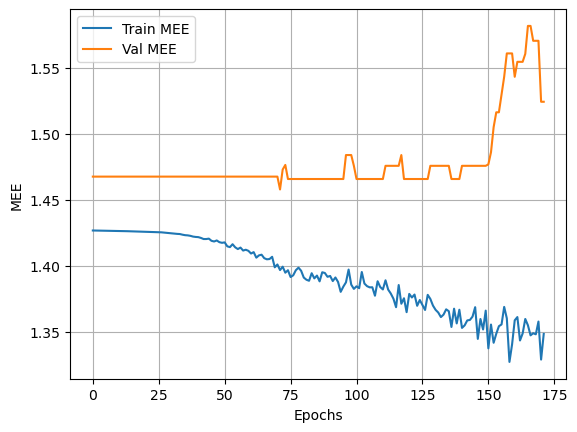

In [30]:
plt.plot(train_losses, label='Train MEE')
plt.plot(val_losses, label='Val MEE')
plt.xlabel('Epochs')
plt.ylabel('MEE')
plt.legend()
plt.grid()
plt.show()

In [32]:
# plot_losses(train_losses, validation_losses)

In [33]:
test_accuracy = []
print(X_test.shape)
# Forward pass

# loss = loss_activation.forward(dense2.output, y_test)
print(loss_function.output.shape)
# Calculate accuracy for this batch
predictions = loss_function.output
# if len(y_test.shape) == 2:
#     y_true = np.argmax(y_batch, axis=1)
# else:
#     y_true = y_test
# accuracy = np.mean(predictions == y_true)
# test_accuracy.append(accuracy)

NameError: name 'X_test' is not defined

In [ ]:
predictions

47.50856431313403

In [ ]:
# best_params = None
# best_mse = float('inf')


# for params in param_combinations:
#     print(f"\nTesting parameters: {params}")
#     fold_val_mses = []
    
#     # K-Fold Cross Validation
#     n_splits = 5
#     indices = np.random.RandomState(seed=42).permutation(len(X))
#     fold_sizes = (len(X) // n_splits) * np.ones(n_splits, dtype=int)
#     fold_sizes[:len(X) % n_splits] += 1
    
#     current = 0
#     for fold in range(n_splits):
#         # Create fold indices
#         start = current
#         end = start + fold_sizes[fold]
#         val_idx = indices[start:end]
#         train_idx = np.concatenate([indices[:start], indices[end:]])
#         current = end

#         # Split data
#         X_train_fold, X_val_fold = X[train_idx], X[val_idx]
#         y_train_fold, y_val_fold = y[train_idx], y[val_idx]

#         # Initialize model with current parameters
#         model = NN(
#             input_size=X.shape[1],
#             hidden_sizes=params['hidden_sizes'],
#             output_size=3,
#             hidden_activations=[params['activations']()],
#             dropout_rates=[params['dropout_rate']] * len(params['hidden_sizes']),
#             l1=params['l1'],
#             l2=params['l2']
#         )
#         optimizer = Optimizer_Adam(learning_rate=params['learning_rate'])
#         loss_function = MSE()

#         # Training loop
#         for epoch in range(params['n_epochs']):
#             # Mini-batch training
#             batch_losses = []
#             for X_batch, y_batch in create_batches(X_train_fold, y_train_fold, params['batch_size']):
#                 # Convert to numpy if using pandas
#                 if isinstance(X_batch, pd.DataFrame):
#                     X_batch = X_batch.values
#                 if isinstance(y_batch, (pd.Series, pd.DataFrame)):
#                     y_batch = y_batch.values
                
#                 # Forward pass
#                 model.forward(X_batch, training=True)
#                 loss = loss_function.forward(model.output, y_batch)
                
#                 # Backward pass
#                 loss_function.backward(model.output, y_batch)
#                 dvalues = loss_function.dinputs
                
#                 # Gradient propagation
#                 for layer in reversed(model.layers):
#                     if hasattr(layer, 'backward'):
#                         layer.backward(dvalues)
#                         dvalues = layer.dinputs
#                         # Convert to numpy if needed
#                         if isinstance(dvalues, pd.DataFrame):
#                             dvalues = dvalues.values
                
#                 # Update parameters
#                 optimizer.pre_update_params()
#                 for layer in model.layers:
#                     if isinstance(layer, Layer_Dense):
#                         optimizer.update_params(layer)
#                 optimizer.post_update_params()
                
#                 batch_losses.append(loss)

#             # Validation
#             model.forward(X_val_fold, training=False)
#             val_loss = loss_function.forward(model.output, y_val_fold)
        
#         fold_val_mses.append(val_loss)
#         print(f"Fold {fold+1} Val MSE: {val_loss:.4f}")

#     # Calculate average performance
#     avg_val_mse = np.mean(fold_val_mses)
#     print(f"Average Validation MSE: {avg_val_mse:.4f}")
    
#     # Update best parameters
#     if avg_val_mse < best_mse:
#         best_mse = avg_val_mse
#         best_params = params

# print("\n=== Best Parameters ===")
# print(best_params)
# print(f"Best Validation MSE: {best_mse:.4f}")

# New Neural Network

In [18]:
# Data Loading & Preprocessing

def normalize(data, scaler=None, type="z-score"):
    if not isinstance(data, pd.DataFrame):
        data = pd.DataFrame(data)
    numeric_data = data.select_dtypes(include=["float64", "int64"])
    if scaler is None:
        scaler = StandardScaler()
        normalized_array = scaler.fit_transform(numeric_data)
    else:
        normalized_array = scaler.transform(numeric_data)
    normalized_data = pd.DataFrame(
        normalized_array, columns=numeric_data.columns, index=numeric_data.index)
    non_numeric_data = data.select_dtypes(exclude=["float64", "int64"])
    if not non_numeric_data.empty:
        final_data = pd.concat([non_numeric_data, normalized_data], axis=1)
    else:
        final_data = normalized_data
    return final_data, scaler


def train_val_split(X, y, val_ratio=0.2, seed=42, shuffle=True):
    assert len(X) == len(y)
    n_samples = len(X)
    n_val = int(n_samples * val_ratio)
    indices = np.arange(n_samples)
    if shuffle:
        np.random.seed(seed)
        np.random.shuffle(indices)
    val_indices = indices[:n_val]
    train_indices = indices[n_val:]
    return X.iloc[train_indices], X.iloc[val_indices], y.iloc[train_indices], y.iloc[val_indices]


def preprocess_data(filepath, normalize_targets=True):
    df = pd.read_csv(filepath, skiprows=7, header=None)
    df.columns = [
        "ID"] + [f'input_{i}' for i in range(12)] + ['target_x', 'target_y', 'target_z']
    df = df.drop('ID', axis=1)
    y = df[['target_x', 'target_y', 'target_z']]
    X = df.drop(['target_x', 'target_y', 'target_z'], axis=1)
    X_normalized, X_scaler = normalize(X)
    X_train, X_val, y_train, y_val = train_val_split(X_normalized, y)
    if normalize_targets:
        y_train_normalized, y_scaler = normalize(y_train)
        y_val_normalized, _ = normalize(y_val, scaler=y_scaler)
        return np.array(X_train), np.array(X_val), np.array(y_train_normalized), np.array(y_val_normalized), X_scaler, y_scaler
    return np.array(X_train), np.array(X_val), np.array(y_train), np.array(y_val), X_scaler, None

In [20]:
# Model Components
class Layer_Dense:
    def __init__(self, n_inputs, n_neurons, l1=0.0, l2=0.0):
        self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))
        self.l1, self.l2 = l1, l2

    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.dot(inputs, self.weights) + self.biases

    def backward(self, dvalues):
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)
        self.dinputs = np.dot(dvalues, self.weights.T)


class Activation_ReLU:
    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.maximum(0, inputs)

    def backward(self, dvalues):
        self.dinputs = dvalues.copy()
        self.dinputs[self.inputs <= 0] = 0


class Activation_Linear:
    def forward(self, inputs):
        self.output = inputs

    def backward(self, dvalues):
        self.dinputs = dvalues.copy()


class Dropout:
    def __init__(self, rate):
        self.rate = rate

    def forward(self, inputs, training=True):
        self.inputs = inputs
        if training:
            self.binary_mask = np.random.binomial(
                1, 1 - self.rate, size=inputs.shape) / (1 - self.rate)
            self.output = inputs * self.binary_mask
        else:
            self.output = inputs

    def backward(self, dvalues):
        self.dinputs = dvalues * self.binary_mask


# class MEE:
#     def forward(self, y_pred, y_true):
#         return np.mean(np.sqrt(np.sum((y_pred - y_true)**2, axis=1)))

#     def backward(self, dvalues, y_true):
#         samples = len(dvalues)
#         differences = dvalues - y_true
#         distances = np.sqrt(np.sum(differences**2, axis=1, keepdims=True))
#         distances = np.maximum(distances, 1e-7)
#         self.dinputs = differences / distances
#         self.dinputs = self.dinputs / (samples * dvalues.shape[1])
#         return self.dinputs

class MSE:
    def forward(self, y_pred, y_true):
        self.y_pred = y_pred
        self.y_true = y_true
        return np.mean((y_pred - y_true) ** 2)

    def backward(self, dvalues, y_true):
        samples = len(dvalues)
        outputs = dvalues.shape[1]
        self.dinputs = (2 * (dvalues - y_true)) / outputs
        self.dinputs = self.dinputs / samples
        return self.dinputs


class Optimizer_Adam:
    def __init__(self, learning_rate=0.001, decay=0.0, epsilon=1e-7):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        self.momentums = {}
        self.caches = {}

    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * \
                (1.0 / (1.0 + self.decay * self.iterations))

    def update_params(self, layer):
        if layer not in self.momentums:
            self.momentums[layer] = {'w': np.zeros_like(
                layer.weights), 'b': np.zeros_like(layer.biases)}
            self.caches[layer] = {'w': np.zeros_like(
                layer.weights), 'b': np.zeros_like(layer.biases)}

        m_w, m_b = self.momentums[layer]['w'], self.momentums[layer]['b']
        c_w, c_b = self.caches[layer]['w'], self.caches[layer]['b']

        m_w = 0.9 * m_w + 0.1 * layer.dweights
        m_b = 0.9 * m_b + 0.1 * layer.dbiases

        c_w = 0.999 * c_w + 0.001 * layer.dweights**2
        c_b = 0.999 * c_b + 0.001 * layer.dbiases**2

        m_w_corr = m_w / (1 - 0.9 ** (self.iterations + 1))
        m_b_corr = m_b / (1 - 0.9 ** (self.iterations + 1))
        c_w_corr = c_w / (1 - 0.999 ** (self.iterations + 1))
        c_b_corr = c_b / (1 - 0.999 ** (self.iterations + 1))

        layer.weights -= self.current_learning_rate * \
            m_w_corr / (np.sqrt(c_w_corr) + self.epsilon)
        layer.biases -= self.current_learning_rate * \
            m_b_corr / (np.sqrt(c_b_corr) + self.epsilon)

        self.momentums[layer]['w'], self.momentums[layer]['b'] = m_w, m_b
        self.caches[layer]['w'], self.caches[layer]['b'] = c_w, c_b

    def post_update_params(self):
        self.iterations += 1

In [22]:
# Neural Network
class NN:
    def __init__(self, input_size, hidden_sizes, output_size, dropout_rates=None):
        self.layers = []
        prev_size = input_size
        if dropout_rates is None:
            dropout_rates = [0.0] * len(hidden_sizes)
        for size, rate in zip(hidden_sizes, dropout_rates):
            self.layers.append(Layer_Dense(prev_size, size))
            self.layers.append(Activation_ReLU())
            if rate > 0:
                self.layers.append(Dropout(rate))
            prev_size = size
        self.layers.append(Layer_Dense(prev_size, output_size))
        self.layers.append(Activation_Linear())

    def forward(self, inputs, training=True):
        for layer in self.layers:
            if isinstance(layer, Dropout):
                layer.forward(inputs, training)
            else:
                layer.forward(inputs)
            inputs = layer.output
        self.output = inputs
        return self.output

    def backward(self, dvalues, y_true=None):
        for layer in reversed(self.layers):
            if hasattr(layer, 'backward'):
                layer.backward(dvalues)
                dvalues = layer.dinputs
        return dvalues

In [23]:
X_train, X_val, y_train, y_val, X_scaler, y_scaler = preprocess_data(
    "../ML_project/data/cup/ML-CUP24-TR.csv")

X_train.shape

(200, 12)

In [24]:
# Training scripts
X_train, X_val, y_train, y_val, X_scaler, y_scaler = preprocess_data(
    "../ML_project/data/cup/ML-CUP24-TR.csv")

model = NN(input_size=12, hidden_sizes=[
           64, 32, 16], output_size=3, dropout_rates=[0.1, 0.1, 0.0])
loss_function = MSE()
optimizer = Optimizer_Adam()

train_losses, val_losses = [], []

epochs = 1000
for epoch in range(epochs):
    # Training
    output = model.forward(X_train, training=True)
    train_loss = loss_function.forward(output, y_train)
    loss_function.backward(output, y_train)
    model.backward(loss_function.dinputs, y_train)
    optimizer.pre_update_params()
    for layer in model.layers:
        if isinstance(layer, Layer_Dense):
            optimizer.update_params(layer)
    optimizer.post_update_params()

    # Validation
    val_pred = model.forward(X_val, training=False)
    val_loss = loss_function.forward(val_pred, y_val)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    if epoch % 10 == 0:
        print(
            f"Epoch {epoch} | Train MEE: {train_loss:.4f} | Val MEE: {val_loss:.4f}")

Epoch 0 | Train MEE: 1.0000 | Val MEE: 0.8866
Epoch 10 | Train MEE: 0.9996 | Val MEE: 0.8861
Epoch 20 | Train MEE: 0.9961 | Val MEE: 0.8824
Epoch 30 | Train MEE: 0.9800 | Val MEE: 0.8656
Epoch 40 | Train MEE: 0.9244 | Val MEE: 0.8083
Epoch 50 | Train MEE: 0.7859 | Val MEE: 0.6700
Epoch 60 | Train MEE: 0.6191 | Val MEE: 0.5250
Epoch 70 | Train MEE: 0.5245 | Val MEE: 0.4353
Epoch 80 | Train MEE: 0.4347 | Val MEE: 0.3678
Epoch 90 | Train MEE: 0.3993 | Val MEE: 0.3478
Epoch 100 | Train MEE: 0.3741 | Val MEE: 0.3232
Epoch 110 | Train MEE: 0.3501 | Val MEE: 0.3011
Epoch 120 | Train MEE: 0.3302 | Val MEE: 0.2809
Epoch 130 | Train MEE: 0.2986 | Val MEE: 0.2641
Epoch 140 | Train MEE: 0.2658 | Val MEE: 0.2438
Epoch 150 | Train MEE: 0.2221 | Val MEE: 0.2141
Epoch 160 | Train MEE: 0.1720 | Val MEE: 0.1781
Epoch 170 | Train MEE: 0.1453 | Val MEE: 0.1400
Epoch 180 | Train MEE: 0.1230 | Val MEE: 0.1220
Epoch 190 | Train MEE: 0.1025 | Val MEE: 0.1113
Epoch 200 | Train MEE: 0.1029 | Val MEE: 0.1062
Epo

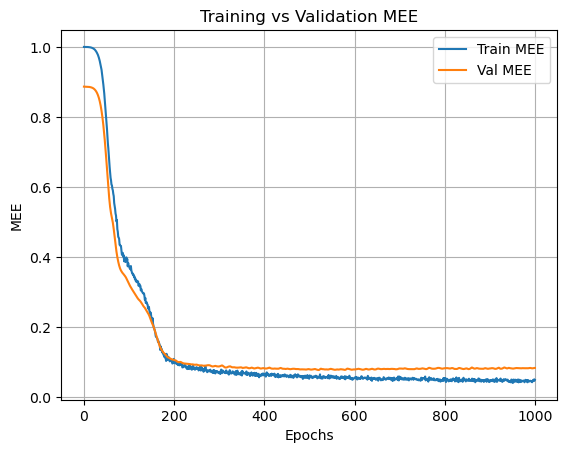

In [18]:
# Plotting
plt.plot(train_losses, label="Train MEE")
plt.plot(val_losses, label="Val MEE")
plt.xlabel("Epochs")
plt.ylabel("MEE")
plt.title("Training vs Validation MEE")
plt.legend()
plt.grid()
plt.show()

In [25]:
filepath_test = "../ML_project/data/cup/ML-CUP24-TS.csv"

df = pd.read_csv(filepath_test, skiprows=7, header=None)
df.columns = ["ID"] + [f'input_{i}' for i in range(12)]
df = df.drop('ID', axis=1)

X_test, _ = normalize(data=df.iloc[:, :12], type='z-score')
X_test = X_test.to_numpy(dtype=np.float32)

X_test.shape


(500, 12)

In [26]:
## Prediction
y_pred = model.forward(X_test, training=False)
y_pred

array([[-0.41030839, -1.4082466 ,  0.68849121],
       [-0.21596747,  1.72858916,  0.69167895],
       [ 0.49877019, -0.00433324, -1.31804159],
       ...,
       [ 0.19738147, -1.42973127,  0.75682715],
       [ 0.21819491,  0.90219082, -1.3052568 ],
       [ 0.29169418,  0.22160196, -0.98136652]])

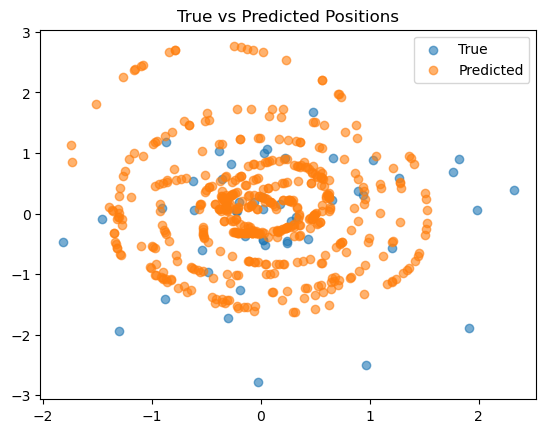

In [27]:
plt.scatter(y_val[:, 0], y_val[:, 1], label="True", alpha=0.6)
plt.scatter(y_pred[:, 0], y_pred[:, 1], label="Predicted", alpha=0.6)
plt.legend()
plt.title("True vs Predicted Positions")
plt.show()

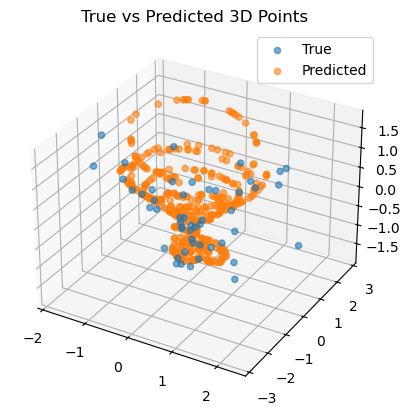

In [28]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(y_val[:, 0], y_val[:, 1], y_val[:, 2], label='True', alpha=0.6)
ax.scatter(y_pred[:, 0], y_pred[:, 1], y_pred[:, 2],
           label='Predicted', alpha=0.6)
ax.set_title("True vs Predicted 3D Points")
ax.legend()
plt.show()